In [1]:
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns

# 問6.4

In [2]:
path =  './Data/msci_day.xls'
df = pl.from_pandas(pd.read_excel(path))

In [3]:
df.head()

Date,ca,fr,ge,it,jp,uk,us
datetime[ns],f64,f64,f64,f64,f64,f64,f64
2003-01-01 00:00:00,560.099,902.081,724.932,290.187,1593.175,791.076,824.583
2003-01-02 00:00:00,574.701,927.206,768.15,296.963,1578.214,797.813,852.219
2003-01-03 00:00:00,580.212,929.297,768.411,298.757,1578.411,800.175,851.935
2003-01-06 00:00:00,589.619,943.002,788.164,303.273,1619.7,803.966,871.515
2003-01-07 00:00:00,585.822,923.785,774.054,297.892,1590.951,793.625,865.992


## (1)

In [11]:
random_walk = np.cumsum(np.random.randn(df.shape[0]))
whitenoize = np.random.randn(df.shape[0])
df = df.with_columns(pl.Series(pl.Series(whitenoize)).alias("white_noize"))
df = df.with_columns(pl.Series(pl.Series(random_walk)).alias("random_walk"))

<Axes: >

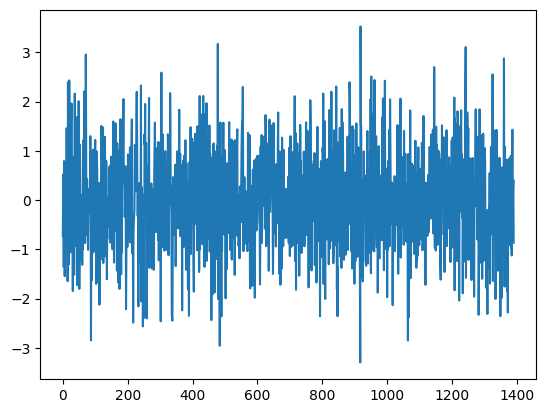

In [12]:
sns.lineplot(whitenoize)

## (2) ホワイトノイズ

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def calc_coef_r2(tmpdf, cols, y):
    model = LinearRegression()
    model.fit(tmpdf.select(cols).to_numpy(), tmpdf.get_column(y).log().to_numpy())
    ans = tmpdf.get_column(y).log().to_numpy()
    pred = model.predict(tmpdf.select(cols).to_numpy())
    
    return r2_score(ans, pred), model.coef_

In [14]:
for a in df.columns:
    if a == "Date" or a == "x" or a == "white_noize" or a == "random_walk":
        continue        
    print(a, calc_coef_r2(["white_noize"], a))

ca (7.07590293269611e-06, array([0.00095132]))
fr (1.1349455786291429e-07, array([-9.77305159e-05]))
ge (7.340907632658045e-06, array([-0.00095701]))
it (7.855525948619047e-07, array([-0.0002223]))
jp (3.564827618418587e-05, array([0.0014126]))
uk (8.15600314862941e-06, array([0.0006633]))
us (5.779689142704214e-05, array([0.00116207]))


## (3) ランダムウォーク

<Axes: >

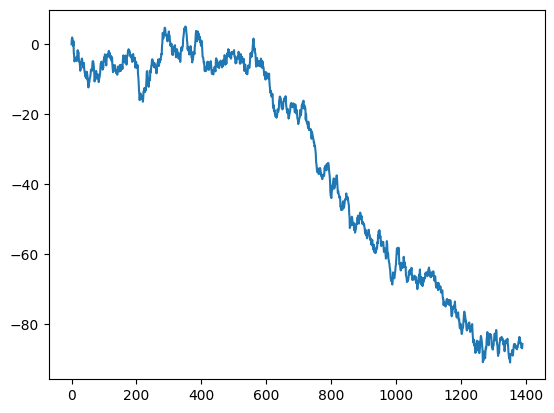

In [15]:
sns.lineplot(random_walk)

In [ ]:
for a in df.columns:
    if a == "Date" or a == "x" or a == "white_noize" or a == "random":
        continue        
    print(a, calc_coef_r2_rand(a))

## (4) ランダムウォークの回帰

In [16]:
for a in df.columns:
    if a == "Date" or a == "x" or a == "white_noize" or a == "random_walk":
        continue        
    print(a, calc_coef_r2(["random_walk"], a))

ca (0.8276153396085594, array([-0.0102431]))
fr (0.7777462929812187, array([-0.0080546]))
ge (0.8021280477195365, array([-0.00995965]))
it (0.6959247412814529, array([-0.00658745]))
jp (0.6082280124501359, array([-0.0058092]))
uk (0.7396568993227308, array([-0.00628885]))
us (0.6963558046345849, array([-0.00401585]))


## (5) 自己再起過程

In [22]:
cols = ["ca", "fr", "ge", "it", "jp", "uk", "us", "random_walk", "white_noize"]
odf = df.with_columns([pl.col(col).shift(1).alias(f"{col}_shift") for col in cols]).drop_nulls()

In [25]:
for a in df.columns:
    if a == "Date" or a == "x" or a == "white_noize" or a == "random_walk":
        continue        
    print(a, calc_coef_r2(odf,["random_walk", "random_walk_shift", f"{a}_shift"], a))

ca (0.9800519440492218, array([0.00181333, 0.00114842, 0.00106176]))
fr (0.9842047501644682, array([0.00131709, 0.00050425, 0.00077728]))
ge (0.9688983098197376, array([0.00065205, 0.00125312, 0.00078959]))
it (0.9882533848138053, array([ 1.16158063e-03, -7.08650139e-05,  2.40044072e-03]))
jp (0.9853837403115149, array([6.06285036e-04, 8.86065321e-05, 4.47135600e-04]))
uk (0.9875359887584065, array([9.85826933e-04, 3.54514594e-05, 9.56062889e-04]))
us (0.9904912158136105, array([0.00024605, 0.000203  , 0.00095998]))


# 問6.5

In [ ]:
aa